### Cab-Driver Agent

In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
#from Env import CabDriver

Using TensorFlow backend.


In [5]:
# Defining hyperparameters
m = 5  # number of cities, ranges from 1 ..... m
t = 24  # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5  # Per hour fuel and other costs
R = 9  # per hour revenue from a passenger


class CabDriver:

    def __init__(self):
        """initialises your state and defines your action space and state space"""
        self.action_space = [[i, j] for i in range(m) for j in range(m) if i != j or i == 0]
        self.state_space = [[i, j, k] for i in range(m) for j in range(t) for k in range(d)]
        self.state_init = [np.random.randint(0, m), np.random.randint(0, t), np.random.randint(0, d)]

        # Start the first round
        self.reset()
        self.total_time = 0
        self.max_time = 24 * 30
        self.action_size = m * (m - 1) + 1

    ## Encoding state (or state-action) for NN input
    def state_trans(self, state):
        """convert the state into a vector so that it can be fed to the NN. This method converts a given state into a
        vector format. Hint: The vector is of size m + t + d. """

        state_encod = np.zeros((m + t + d))
        state_encod[state[0]] = 1
        state_encod[m + np.int(state[1])] = 1
        state_encod[m + t + np.int(state[2])] = 2

        return state_encod

    def requests(self, state):
        """Determining the number of requests basis the location. Use the table specified in the problem and complete
        for rest of the locations """
        location = state[0]
        if location == 0:
            requests = np.random.poisson(2)

        elif location == 1:
            requests = np.random.poisson(12)

        elif location == 2:
            requests = np.random.poisson(4)

        elif location == 3:
            requests = np.random.poisson(7)

        else:
            requests = np.random.poisson(8)

        if requests > 15:
            requests = 15

        possible_actions_index = random.sample(range(1, self.action_size), requests)
        actions = [self.action_space[i] for i in possible_actions_index]

        # [0, 0] is not a 'request', but it is one of the possible actions
        actions.append([0, 0])
        possible_actions_index.append(0)
        return possible_actions_index, actions

    def reward_func(self, state, action, Time_matrix):
        """Takes in state, action and Time-matrix and returns the reward"""
        start_loc, time, day = state
        pickup, drop = action

        if pickup == 0 and drop == 0:
            return -5
        else:
            """calculate the reward for the (pickup, drop) kind of actions"""
            time_elapsed_till_pickup = Time_matrix[start_loc, pickup, int(time), int(day)]

            # when pickup is not same as current location, current time and day could change

            time_next = (time + time_elapsed_till_pickup) % t
            day_next = (day + (time + time_elapsed_till_pickup) // t) % d

            return (R * Time_matrix[pickup, drop, int(time_next), int(day_next)] - C * (
                    Time_matrix[pickup, drop, int(time_next), int(day_next)] + Time_matrix[
                start_loc, pickup, int(time), int(day)]))

    def next_state_func(self, state, action, Time_matrix):
        """Takes state and action as input and returns next state"""
        start_loc, time, day = state
        pickup, drop = action

        if pickup == 0 and drop == 0:
            # when action is (0,0)
            time_elapsed = 1

            self.total_time = self.total_time + time_elapsed
        else:

            # when pickup is not same as current location, current time and day could change

            time_elapsed_till_pickup = Time_matrix[start_loc, pickup, int(time), int(day)]
            time_next_temp = (time + time_elapsed_till_pickup) % t
            day_next_temp = (day + (time + time_elapsed_till_pickup) // t) % d

            time = time_next_temp
            day = day_next_temp

            time_elapsed = Time_matrix[pickup, drop, int(time), int(day)]

            self.total_time = self.total_time + time_elapsed + time_elapsed_till_pickup

        time_next = (time + time_elapsed) % t
        day_next = (day + (time + time_elapsed) // t) % d

        time_next = np.int(time_next)
        day_next = np.int(day_next)

        # check whether it is a terminal state
        if self.total_time >= self.max_time:
            terminal_state = 1
            self.total_time = 0
        else:
            terminal_state = 0

        terminal_state = bool(terminal_state)  # returns terminal state as True or False

        next_state = [drop, time_next, day_next]

        return next_state, terminal_state

    def reset(self):
        return self.state_init

#### Defining Time Matrix

In [6]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [7]:
states_track = collections.defaultdict(dict)

def initialise_states_for_tracking():
    #select any 5  Q-values
    sample_q_values = [((4,3,2),(4,1)),((3,4,2),(2,3)),((2,2,2),(3,2)),((1,22,4),(1,3)), ((4,24,3),(3,4))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        #this is an array which will have appended values of that state-action pair for every 25th episode         
        states_track[state][action] = []

In [8]:
initialise_states_for_tracking()

In [9]:
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            action_index = env.action_space.index(action_list)
            Q = prediction[0][action_index]
            states_track[state][action].append(Q)

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
t = 24  
d = 7   
class DQNAgent:
    def __init__(self, state_size, action_size):

        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]
      
        # These are hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in e after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
            
        return action, epsilon
        
        
    # save sample <s,a,r,s'> to the replay memory 
    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminal_states = [], [], []
       
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_trans(state)
            update_output[i] = env.state_trans(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                   
    def save(self, name):
        self.model.save_weights(name)

In [12]:
Episodes = 10000

In [13]:
import os

In [14]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")
    
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)
action_space = env.action_space
Time_matrix = np.load("TM.npy")

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

### DQN block

In [15]:
for episode in range(Episodes):
    # Write code here
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    
    while not terminal_state:    
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action, epsilon = agent.get_action(state, episode)
        
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_matrix)
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # 5. Keep a track of rewards, Q-values, loss
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode,"  no of steps:",step_count, "  score:", tot_reward, "  avg score:", round(tot_reward/step_count,4),
                  "  memorylength:", len(agent.memory), "  epsilon:", epsilon)
        
        if episode % 25 == 0:   #every 25 episode
            save_tracking_states()
        
        if episode % 1000 ==0 and episode !=0:
            Rewardname = "saved_pickle_files/Rewards"+str(episode)
            Statesname = "saved_pickle_files/States_tracked"+str(episode)
            save_obj(avg_reward,Rewardname)  
            save_obj(states_track,Statesname)
            agent.save("./cab_driver.h5")

episode: 0   no of steps: 146   score: -90.0   avg score: -0.6164   memorylength: 146   epsilon: 1.0
episode: 25   no of steps: 130   score: -144.0   avg score: -1.1077   memorylength: 2000   epsilon: 0.9925280548938579
episode: 50   no of steps: 142   score: -374.0   avg score: -2.6338   memorylength: 2000   epsilon: 0.9851119397519432
episode: 75   no of steps: 156   score: -464.0   avg score: -2.9744   memorylength: 2000   epsilon: 0.9777512374158239
episode: 100   no of steps: 151   score: -29.0   avg score: -0.1921   memorylength: 2000   epsilon: 0.9704455338440529
episode: 125   no of steps: 153   score: -321.0   avg score: -2.098   memorylength: 2000   epsilon: 0.9631944180888776
episode: 150   no of steps: 150   score: -106.0   avg score: -0.7067   memorylength: 2000   epsilon: 0.9559974822731252
episode: 175   no of steps: 146   score: -88.0   avg score: -0.6027   memorylength: 2000   epsilon: 0.948854321567258
episode: 200   no of steps: 162   score: -447.0   avg score: -2.75

episode: 1750   no of steps: 138   score: 621.0   avg score: 4.5   memorylength: 2000   epsilon: 0.5915553684512614
episode: 1775   no of steps: 135   score: 264.0   avg score: 1.9556   memorylength: 2000   epsilon: 0.5871352992414688
episode: 1800   no of steps: 142   score: 529.0   avg score: 3.7254   memorylength: 2000   epsilon: 0.5827482565465072
episode: 1825   no of steps: 144   score: 98.0   avg score: 0.6806   memorylength: 2000   epsilon: 0.5783939935940685
episode: 1850   no of steps: 112   score: 160.0   avg score: 1.4286   memorylength: 2000   epsilon: 0.5740722654557134
episode: 1875   no of steps: 112   score: 115.0   avg score: 1.0268   memorylength: 2000   epsilon: 0.5697828290330947
episode: 1900   no of steps: 123   score: 362.0   avg score: 2.9431   memorylength: 2000   epsilon: 0.5655254430442828
episode: 1925   no of steps: 129   score: 79.0   avg score: 0.6124   memorylength: 2000   epsilon: 0.5612998680101929
episode: 1950   no of steps: 139   score: 349.0   avg

episode: 3475   no of steps: 140   score: 553.0   avg score: 3.95   memorylength: 2000   epsilon: 0.3525721553541629
episode: 3500   no of steps: 133   score: 538.0   avg score: 4.0451   memorylength: 2000   epsilon: 0.3499377556117779
episode: 3525   no of steps: 134   score: 310.0   avg score: 2.3134   memorylength: 2000   epsilon: 0.34732303995985236
episode: 3550   no of steps: 125   score: 413.0   avg score: 3.304   memorylength: 2000   epsilon: 0.3447278613199416
episode: 3575   no of steps: 153   score: 444.0   avg score: 2.902   memorylength: 2000   epsilon: 0.3421520737125628
episode: 3600   no of steps: 140   score: 881.0   avg score: 6.2929   memorylength: 2000   epsilon: 0.3395955322489839
episode: 3625   no of steps: 146   score: 753.0   avg score: 5.1575   memorylength: 2000   epsilon: 0.33705809312307344
episode: 3650   no of steps: 143   score: 745.0   avg score: 5.2098   memorylength: 2000   epsilon: 0.33453961360321155
episode: 3675   no of steps: 122   score: 660.0  

episode: 5200   no of steps: 146   score: 1326.0   avg score: 9.0822   memorylength: 2000   epsilon: 0.21013607909940404
episode: 5225   no of steps: 146   score: 971.0   avg score: 6.6507   memorylength: 2000   epsilon: 0.20856595391057153
episode: 5250   no of steps: 131   score: 920.0   avg score: 7.0229   memorylength: 2000   epsilon: 0.2070075606110771
episode: 5275   no of steps: 136   score: 1161.0   avg score: 8.5368   memorylength: 2000   epsilon: 0.20546081154088675
episode: 5300   no of steps: 137   score: 873.0   avg score: 6.3723   memorylength: 2000   epsilon: 0.20392561969495734
episode: 5325   no of steps: 144   score: 915.0   avg score: 6.3542   memorylength: 2000   epsilon: 0.20240189871834283
episode: 5350   no of steps: 116   score: 1344.0   avg score: 11.5862   memorylength: 2000   epsilon: 0.20088956290133655
episode: 5375   no of steps: 138   score: 826.0   avg score: 5.9855   memorylength: 2000   epsilon: 0.19938852717464997
episode: 5400   no of steps: 146   sc

episode: 6925   no of steps: 149   score: 1314.0   avg score: 8.8188   memorylength: 2000   epsilon: 0.12524293720910526
episode: 6950   no of steps: 130   score: 1043.0   avg score: 8.0231   memorylength: 2000   epsilon: 0.12430712892270818
episode: 6975   no of steps: 145   score: 1173.0   avg score: 8.0897   memorylength: 2000   epsilon: 0.12337831294452688
episode: 7000   no of steps: 166   score: 907.0   avg score: 5.4639   memorylength: 2000   epsilon: 0.12245643702841766
episode: 7025   no of steps: 160   score: 1181.0   avg score: 7.3812   memorylength: 2000   epsilon: 0.12154144931861711
episode: 7050   no of steps: 158   score: 938.0   avg score: 5.9367   memorylength: 2000   epsilon: 0.12063329834682542
episode: 7075   no of steps: 156   score: 1134.0   avg score: 7.2692   memorylength: 2000   epsilon: 0.11973193302931089
episode: 7100   no of steps: 170   score: 1305.0   avg score: 7.6765   memorylength: 2000   epsilon: 0.1188373026640367
episode: 7125   no of steps: 130   

episode: 8625   no of steps: 151   score: 1168.0   avg score: 7.7351   memorylength: 2000   epsilon: 0.07520783406657415
episode: 8650   no of steps: 152   score: 1061.0   avg score: 6.9803   memorylength: 2000   epsilon: 0.07464588532797684
episode: 8675   no of steps: 172   score: 1251.0   avg score: 7.2733   memorylength: 2000   epsilon: 0.07408813543954879
episode: 8700   no of steps: 153   score: 1425.0   avg score: 9.3137   memorylength: 2000   epsilon: 0.07353455302771165
episode: 8725   no of steps: 141   score: 1560.0   avg score: 11.0638   memorylength: 2000   epsilon: 0.07298510695330888
episode: 8750   no of steps: 173   score: 1393.0   avg score: 8.052   memorylength: 2000   epsilon: 0.07243976630985392
episode: 8775   no of steps: 177   score: 1150.0   avg score: 6.4972   memorylength: 2000   epsilon: 0.0718985004217917
episode: 8800   no of steps: 152   score: 1206.0   avg score: 7.9342   memorylength: 2000   epsilon: 0.07136127884277338
episode: 8825   no of steps: 145 

### Tracking Convergence

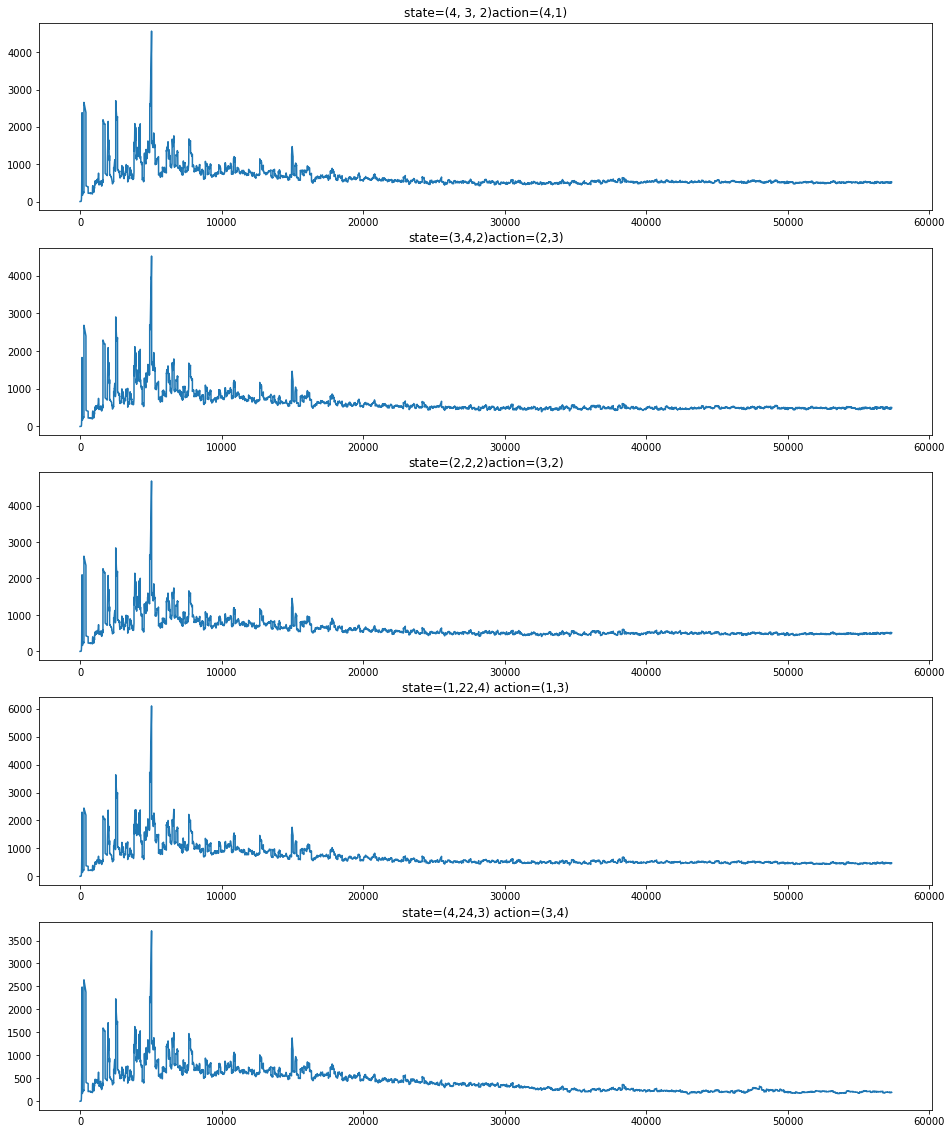

In [40]:
xaxis = list(range(0, 20000,25))

plt.figure(0, figsize=(16,20))
size = len(list(states_track[(4, 3, 2)].values())[0])
plt.subplot(511)
plt.title('state=(4, 3, 2)action=(4,1)')
plt.plot(list(states_track[(4, 3, 2)].values())[0])
plt.subplot(512)
plt.title('state=(3,4,2)action=(2,3)')
plt.plot(list(states_track[(3, 4, 2)].values())[0])
plt.subplot(513)
plt.title('state=(2,2,2)action=(3,2)')
plt.plot(list(states_track[(2, 2, 2)].values())[0])
plt.subplot(514)
plt.title('state=(1,22,4) action=(1,3)')
plt.plot(list(states_track[(1, 22, 4)].values())[0])
plt.subplot(515)
plt.title('state=(4,24,3) action=(3,4)')
plt.plot(list(states_track[(4, 24, 3)].values())[0])
plt.show()